In [1]:
import anndata
import torch
import stPlus

import squidpy as sq
import numpy as np
import scanpy as sc
import pandas as pd

from sklearn.model_selection import KFold
from transpa.eval_util import calc_corr
from transpa.util import expTransImp, leiden_cluster, compute_autocorr
from benchmark import SpaGE_impute, Tangram_impute
import warnings

warnings.filterwarnings('ignore')

seed = 10
device = torch.device("cuda:1") if torch.cuda.is_available() else torch.device("cpu")
# device = torch.device("cpu")

In [2]:
spa_adata = sc.read_h5ad("../../data/ST/melanoma/spatial.h5ad")
spa_adata = spa_adata[:, (spa_adata.var_names.values != 'MARCH1') & (spa_adata.var_names.values != 'MARCH2')].copy()
rna_adata = sc.read_h5ad("../../data/scRNAseq/melanoma/Tirosh_raw.h5ad")
rna_adata = rna_adata[:, (rna_adata.var_names.values != 'MARCH1') & (rna_adata.var_names.values != 'MARCH2')].copy()

In [3]:
classes, ct_list = leiden_cluster(rna_adata, False)
cls_key = 'leiden'
rna_adata.obs[cls_key] = classes
sq.gr.spatial_neighbors(spa_adata, n_neighs=4)
sq.gr.spatial_autocorr(
    spa_adata,
    n_jobs=10,
)
spa_adata =  spa_adata[:, spa_adata.uns['moranI'].I > 0].copy()
rna_adata, spa_adata


(AnnData object with n_obs × n_vars = 4645 × 23682
     obs: 'celltype', 'malignant', 'leiden',
 AnnData object with n_obs × n_vars = 293 × 7444
     obs: 'B', 'CAF', 'Endo', 'Macro', 'Melanoma or unclassified', 'NK', 'T'
     uns: 'spatial_neighbors', 'moranI'
     obsm: 'spatial'
     obsp: 'spatial_connectivities', 'spatial_distances')

In [4]:
raw_spatial_df  = pd.DataFrame(spa_adata.X, columns=spa_adata.var_names)
raw_scrna_df    = pd.DataFrame(rna_adata.X, columns=rna_adata.var_names)

raw_shared_gene = np.intersect1d(raw_spatial_df.columns, raw_scrna_df.columns)
raw_spatial_df.shape, raw_scrna_df.shape, raw_shared_gene.shape

((293, 7444), (4645, 23682), (7168,))

In [5]:
spa_adata.uns['moranI']

,I,pval_norm,var_norm,pval_norm_fdr_bh
SPP1,0.643983,0.000000,0.001692,0.000000
CH507-513H4.5,0.624008,0.000000,0.001692,0.000000
GAPDH,0.608377,0.000000,0.001692,0.000000
MCAM,0.580156,0.000000,0.001692,0.000000
CD74,0.560946,0.000000,0.001692,0.000000
...,...,...,...,...
TUBGCP2,-0.106017,0.006311,0.001692,0.071659
MGRN1,-0.106481,0.006113,0.001692,0.069878
PPIE,-0.113956,0.003602,0.001692,0.047282
AHDC1,-0.114407,0.003485,0.001692,0.046279


In [6]:
spa_shared = spa_adata[:, raw_shared_gene].copy()
rna_shared = rna_adata[:, raw_shared_gene].copy()
raw_spatial_df  = pd.DataFrame(spa_shared.X, columns=spa_shared.var_names)
raw_scrna_df    = pd.DataFrame(rna_shared.X, columns=rna_shared.var_names)

raw_shared_gene = np.intersect1d(raw_spatial_df.columns, raw_scrna_df.columns)
raw_spatial_df.shape, raw_scrna_df.shape, raw_shared_gene.shape

((293, 7168), (4645, 7168), (7168,))

In [7]:
neg_genes = np.random.choice(spa_shared.var_names[spa_shared.uns['moranI'].loc[raw_shared_gene].pval_norm_fdr_bh.values >= 0.01], 50, replace=False)
pos_genes = np.random.choice(spa_shared.var_names[spa_shared.uns['moranI'].loc[raw_shared_gene].pval_norm_fdr_bh.values < 0.01], 50, replace=False)

train_gene = np.union1d(pos_genes, neg_genes)
test_gene = np.setdiff1d(raw_shared_gene, train_gene)
len(np.unique(train_gene)), len(test_gene)

(100, 7068)

In [8]:
df_transImpSpa = pd.DataFrame(np.zeros((spa_adata.n_obs, len(raw_shared_gene))), columns=raw_shared_gene)
df_transImpCls = pd.DataFrame(np.zeros((spa_adata.n_obs, len(raw_shared_gene))), columns=raw_shared_gene)
df_transImpClsSpa = pd.DataFrame(np.zeros((spa_adata.n_obs, len(raw_shared_gene))), columns=raw_shared_gene)
df_transImp = pd.DataFrame(np.zeros((spa_adata.n_obs, len(raw_shared_gene))), columns=raw_shared_gene)
df_stplus_res = pd.DataFrame(np.zeros((spa_adata.n_obs, len(raw_shared_gene))), columns=raw_shared_gene)
df_spaGE_res = pd.DataFrame(np.zeros((spa_adata.n_obs, len(raw_shared_gene))), columns=raw_shared_gene)
df_tangram_res = pd.DataFrame(np.zeros((spa_adata.n_obs, len(raw_shared_gene))), columns=raw_shared_gene)

# for idx, (train_ind, test_ind) in enumerate(kf.split(raw_shared_gene)):    
print(f"\n==========\nNumber of train genes: {len(train_gene)}, Number of test genes: {len(test_gene)}")

test_spatial_df = raw_spatial_df[test_gene]
spatial_df = raw_spatial_df[train_gene]
scrna_df   = raw_scrna_df

df_transImpSpa[test_gene] = expTransImp(
        df_ref=raw_scrna_df,
        df_tgt=raw_spatial_df,
        train_gene=train_gene,
        test_gene=test_gene,
        signature_mode='cell',
        clip_max=2,
        mapping_lowdim=128,
        mapping_mode='lowrank',
        spa_adj=spa_adata.obsp['spatial_connectivities'].tocoo(),
        seed=seed,
        device=device)

corr_transImpSpa_res = calc_corr(raw_spatial_df, df_transImpSpa, test_gene)
print(f'Median correlation: {np.median(corr_transImpSpa_res)} (TransImpSpa)')

df_transImpCls[test_gene] = expTransImp(
        df_ref=raw_scrna_df,
        df_tgt=raw_spatial_df,
        train_gene=train_gene,
        test_gene=test_gene,
        ct_list=ct_list,
        classes=classes,
        signature_mode='cluster',
        mapping_mode='full',
        seed=seed,
        device=device)

corr_transImpSpa_res = calc_corr(raw_spatial_df, df_transImpCls, test_gene)
print(f'Median correlation: {np.median(corr_transImpSpa_res)} (TransImpCls)')

df_transImp[test_gene] = expTransImp(
        df_ref=raw_scrna_df,
        df_tgt=raw_spatial_df,
        train_gene=train_gene,
        test_gene=test_gene,
        signature_mode='cell',
        mapping_lowdim=128,
        mapping_mode='lowrank',
        clip_max=2,
        seed=seed,
        device=device)

corr_transImpSpa_res = calc_corr(raw_spatial_df, df_transImp, test_gene)
print(f'Median correlation: {np.median(corr_transImpSpa_res)} (TransImp)')

df_transImpClsSpa[test_gene] = expTransImp(
        df_ref=raw_scrna_df,
        df_tgt=raw_spatial_df,
        train_gene=train_gene,
        test_gene=test_gene,
        ct_list=ct_list,
        classes=classes,
        spa_adj=spa_adata.obsp['spatial_connectivities'].tocoo(),
        signature_mode='cluster',
        mapping_mode='full',
        seed=seed,
        device=device)

corr_transImpSpa_res = calc_corr(raw_spatial_df, df_transImpClsSpa, test_gene)
print(f'Median correlation: {np.median(corr_transImpSpa_res)} (TransImpClsSpa)')

df_stplus_res[test_gene] = stPlus.stPlus(spatial_df, scrna_df, test_gene, "tmp_stvisp", top_k=100, verbose=False, random_seed=seed, device=device)
corr_res_stplus = calc_corr(raw_spatial_df, df_stplus_res, test_gene)
print(f'\t\t\t{np.median(corr_res_stplus)} (stPlus)')

df_spaGE_res[test_gene]  = SpaGE_impute(scrna_df, spatial_df, train_gene, test_gene)
corr_res_spaGE = calc_corr(raw_spatial_df, df_spaGE_res, test_gene)
print(f'\t\t\t{np.median(corr_res_spaGE)} (spaGE)')

df_tangram_res[test_gene] = Tangram_impute(rna_adata, spa_adata, train_gene, test_gene, device, cls_key)
corr_res_tangram = calc_corr(raw_spatial_df, df_tangram_res, test_gene)
print(f'\t\t\t{np.median(corr_res_tangram)} (Tangram)')

corr_transImpSpa_res = calc_corr(raw_spatial_df, df_transImpSpa, test_gene)
corr_transImp_res = calc_corr(raw_spatial_df, df_transImp, test_gene)
corr_transImpCls_res = calc_corr(raw_spatial_df, df_transImpCls, test_gene)
corr_transImpClsSpa_res = calc_corr(raw_spatial_df, df_transImpClsSpa, test_gene)
corr_res_stplus = calc_corr(raw_spatial_df, df_stplus_res, test_gene)
corr_res_spaGE = calc_corr(raw_spatial_df, df_spaGE_res, test_gene)
corr_res_tangram = calc_corr(raw_spatial_df, df_tangram_res, test_gene)   

print(np.median(corr_transImpSpa_res), "(TransImpSpa)", 
np.median(corr_transImp_res), "(TransImp)", 
np.median(corr_transImpCls_res), "(TransImpCls)", 
np.median(corr_transImpClsSpa_res), "(TransImpClsSpa)", 
np.median(corr_res_stplus), "(stPlus)", 
np.median(corr_res_spaGE), "(spaGE)",
np.median(corr_res_tangram), "(Tangram)"
)


Number of train genes: 100, Number of test genes: 7068


[TransImp] Epoch: 1000/1000, loss: 0.575924, (IMP) 0.575273, (SPA) 1.0 x 0.000650: 100%|██████████| 1000/1000 [00:04<00:00, 224.54it/s]


Median correlation: 0.1569325300542375 (TransImpSpa)


[TransImp] Epoch: 1000/1000, loss: 0.593356, (IMP) 0.593356, (SPA) 1.0 x 0.000000: 100%|██████████| 1000/1000 [00:02<00:00, 447.34it/s]


Median correlation: 0.17825251808737275 (TransImpCls)


[TransImp] Epoch: 1000/1000, loss: 0.564900, (IMP) 0.564900, (SPA) 1.0 x 0.000000: 100%|██████████| 1000/1000 [00:02<00:00, 385.28it/s]


Median correlation: 0.17526201514412795 (TransImp)


[TransImp] Epoch: 1000/1000, loss: 0.602888, (IMP) 0.599175, (SPA) 1.0 x 0.003713: 100%|██████████| 1000/1000 [00:03<00:00, 286.39it/s]


Median correlation: 0.14821890220839945 (TransImpClsSpa)
			0.1614692108295364 (stPlus)
			0.1627871980042158 (spaGE)


INFO:root:100 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:100 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 100 genes and rna_count_based density_prior in clusters mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.485, KL reg: 0.071
Score: 0.602, KL reg: 0.001
Score: 0.603, KL reg: 0.001
Score: 0.604, KL reg: 0.001
Score: 0.604, KL reg: 0.001
Score: 0.604, KL reg: 0.001
Score: 0.604, KL reg: 0.001
Score: 0.604, KL reg: 0.001
Score: 0.604, KL reg: 0.001
Score: 0.604, KL reg: 0.001


INFO:root:Saving results..


			0.18482083620727563 (Tangram)
0.1569325300542375 (TransImpSpa) 0.17526201514412795 (TransImp) 0.17825251808737275 (TransImpCls) 0.14821890220839945 (TransImpClsSpa) 0.1614692108295364 (stPlus) 0.1627871980042158 (spaGE) 0.18482083620727563 (Tangram)


In [9]:
df_transImp.to_csv('../../output/melanomaext_singlecell_transImpute.csv')
df_transImpSpa.to_csv('../../output/melanomaext_singlecell_transImpSpa.csv')
df_transImpCls.to_csv('../../output/melanomaext_singlecell_transImpCls.csv')
df_transImpClsSpa.to_csv('../../output/melanomaext_singlecell_transImpClsSpa.csv')
df_spaGE_res.to_csv('../../output/melanomaext_singlecell_spaGE.csv')
df_stplus_res.to_csv('../../output/melanomaext_singlecell_stPlus.csv')
df_tangram_res.to_csv('../../output/melanomaext_singlecell_Tangram.csv')


In [10]:
dict_df = {
        "TransImp":df_transImp[test_gene], 
           "TransImpSpa":df_transImpSpa[test_gene], 
           "TransImpCls":df_transImpCls[test_gene],
           "TransImpClsSpa":df_transImpClsSpa[test_gene],
           "spaGE": df_spaGE_res[test_gene], 
           "stPlus": df_stplus_res[test_gene], 
           "Tangram":df_tangram_res[test_gene]
        }

dict_adata = {name: compute_autocorr(spa_shared[:, test_gene].copy(), df) for name, df in dict_df.items()}


In [11]:
import scanpy as sc
import pandas as pd
import numpy as np
import squidpy as sq
import seaborn as sns
import os
import torch
import pickle


from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from tqdm import tqdm
from transpa.util import compute_autocorr
from transpa.eval_util import calc_corr
from transpa.util import leiden_cluster
import warnings



with open("../../output/melanomaext_small_train_genes.pkl", 'wb') as outfile:
    pickle.dump((train_gene, test_gene), outfile)

warnings.filterwarnings('ignore')
device = torch.device("cuda:1") if torch.cuda.is_available() else torch.device("cpu")
eval_res_path = "../../output/melanomaext_small_train_eval_results.pkl"
is_reeval = True

seed = 10
thred = 0.01


In [12]:
spa_shared

AnnData object with n_obs × n_vars = 293 × 7168
    obs: 'B', 'CAF', 'Endo', 'Macro', 'Melanoma or unclassified', 'NK', 'T'
    uns: 'spatial_neighbors', 'moranI'
    obsm: 'spatial'
    obsp: 'spatial_connectivities', 'spatial_distances'

In [13]:
if is_reeval:
    spa_adata = spa_shared[:, test_gene].copy()
    df_spa = pd.DataFrame(spa_adata.X, columns=spa_adata.var_names)

    imp_adatas = {}
    eval_res = {'se_moranI':{}, 'pred_corr':{}, 'is_sig':{}, 'I':{}, 'spatialDE_stats':{}, 'spatialDE_qvals':{}}
    for method  in tqdm(['stPlus', 'spaGE', 'Tangram', 'TransImp', 'TransImpSpa', 'TransImpCls', 'TransImpClsSpa']):
   
        imp_adata = dict_adata[method]
        df_res = dict_df[method]
        imp_adata = dict_adata[method]
        corrs = calc_corr(df_spa, df_res, df_res.columns)
        sq.gr.spatial_neighbors(imp_adata, coord_type ='grid', n_neighs=6)
        sq.gr.spatial_autocorr(
            imp_adata,
            n_jobs=20,
            mode='moran',
        )

        if not is_reeval:
            continue

       
        is_sig = imp_adata.uns['moranI'].pval_norm_fdr_bh.values
        squ_err_moranI = np.square(spa_adata.uns['moranI'].loc[imp_adata.var_names].I.values - imp_adata.uns['moranI'].I.values)
        eval_res['se_moranI'][method] = squ_err_moranI
        eval_res['pred_corr'][method] = pd.Series(np.array(corrs), df_res.columns)
        eval_res['is_sig'][method] = pd.Series(is_sig, df_res.columns)
        eval_res['I'][method] = pd.Series(imp_adata.uns['moranI'].I, df_res.columns)
       
    with open(eval_res_path, 'wb') as outfile:
        pickle.dump((eval_res, spa_adata, dict_adata), outfile)


100%|██████████| 7/7 [00:23<00:00,  3.33s/it]


In [14]:
np.unique(spa_adata.uns['moranI'].pval_norm_fdr_bh < .01, return_counts=True)

(array([False,  True]), array([15340,   806]))

In [15]:

df_se_moranI = pd.DataFrame(dict(sorted(eval_res['se_moranI'].items())))
df_corr      = pd.DataFrame(dict(sorted(eval_res['pred_corr'].items())))
df_issig     = pd.DataFrame(dict(sorted(eval_res['is_sig'].items())))
df_spatialDE_stats = pd.DataFrame(dict(sorted(eval_res['spatialDE_stats'].items())))
df_spatialDE_pvals = pd.DataFrame(dict(sorted(eval_res['spatialDE_qvals'].items())))

df_I     = pd.DataFrame(dict(sorted(eval_res['I'].items())))
df_issig['truth'] = spa_adata.uns['moranI'].loc[df_issig.index.values,:].pval_norm_fdr_bh
df_I['truth'] = spa_adata.uns['moranI'].loc[df_issig.index.values,:].I

imp_adatas = dict(sorted(imp_adatas.items()))
df_issig

,Tangram,TransImp,TransImpCls,TransImpClsSpa,TransImpSpa,spaGE,stPlus,truth
A1BG,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,5.000000e-01
A2M,0.000000,0.000000,0.000000,3.923528e-13,0.000000,0.000000,0.000000,4.129924e-09
AAAS,0.000000,0.000000,0.000000,3.923528e-13,0.000000,0.000000,0.000000,1.378774e-01
AACS,0.000000,0.000000,0.000000,3.923528e-13,0.000000,0.000000,0.000000,5.000000e-01
AAED1,0.000000,0.000000,0.000000,1.255529e-12,0.000000,0.000000,0.000000,5.000000e-01
...,...,...,...,...,...,...,...,...
ZSWIM6,0.478970,0.263347,0.481871,3.200899e-02,0.115519,0.116084,0.104301,5.000000e-01
ZSWIM7,0.450917,0.264257,0.419096,2.339029e-02,0.057804,0.082226,0.098306,5.000000e-01
ZW10,0.320356,0.309304,0.406624,1.392500e-02,0.045548,0.061713,0.082521,5.000000e-01
ZYX,0.235823,0.312232,0.386959,9.788869e-03,0.024978,0.053773,0.074550,4.891319e-01


(Tangram) Valid genes: 4670/7068
Tangram
FPR: 0.963500
(TransImp) Valid genes: 4670/7068
TransImp
FPR: 0.995407
(TransImpSpa) Valid genes: 4670/7068
TransImpSpa
FPR: 0.722746
(spaGE) Valid genes: 4670/7068
spaGE
FPR: 0.896785
(stPlus) Valid genes: 4670/7068
stPlus
FPR: 0.930868


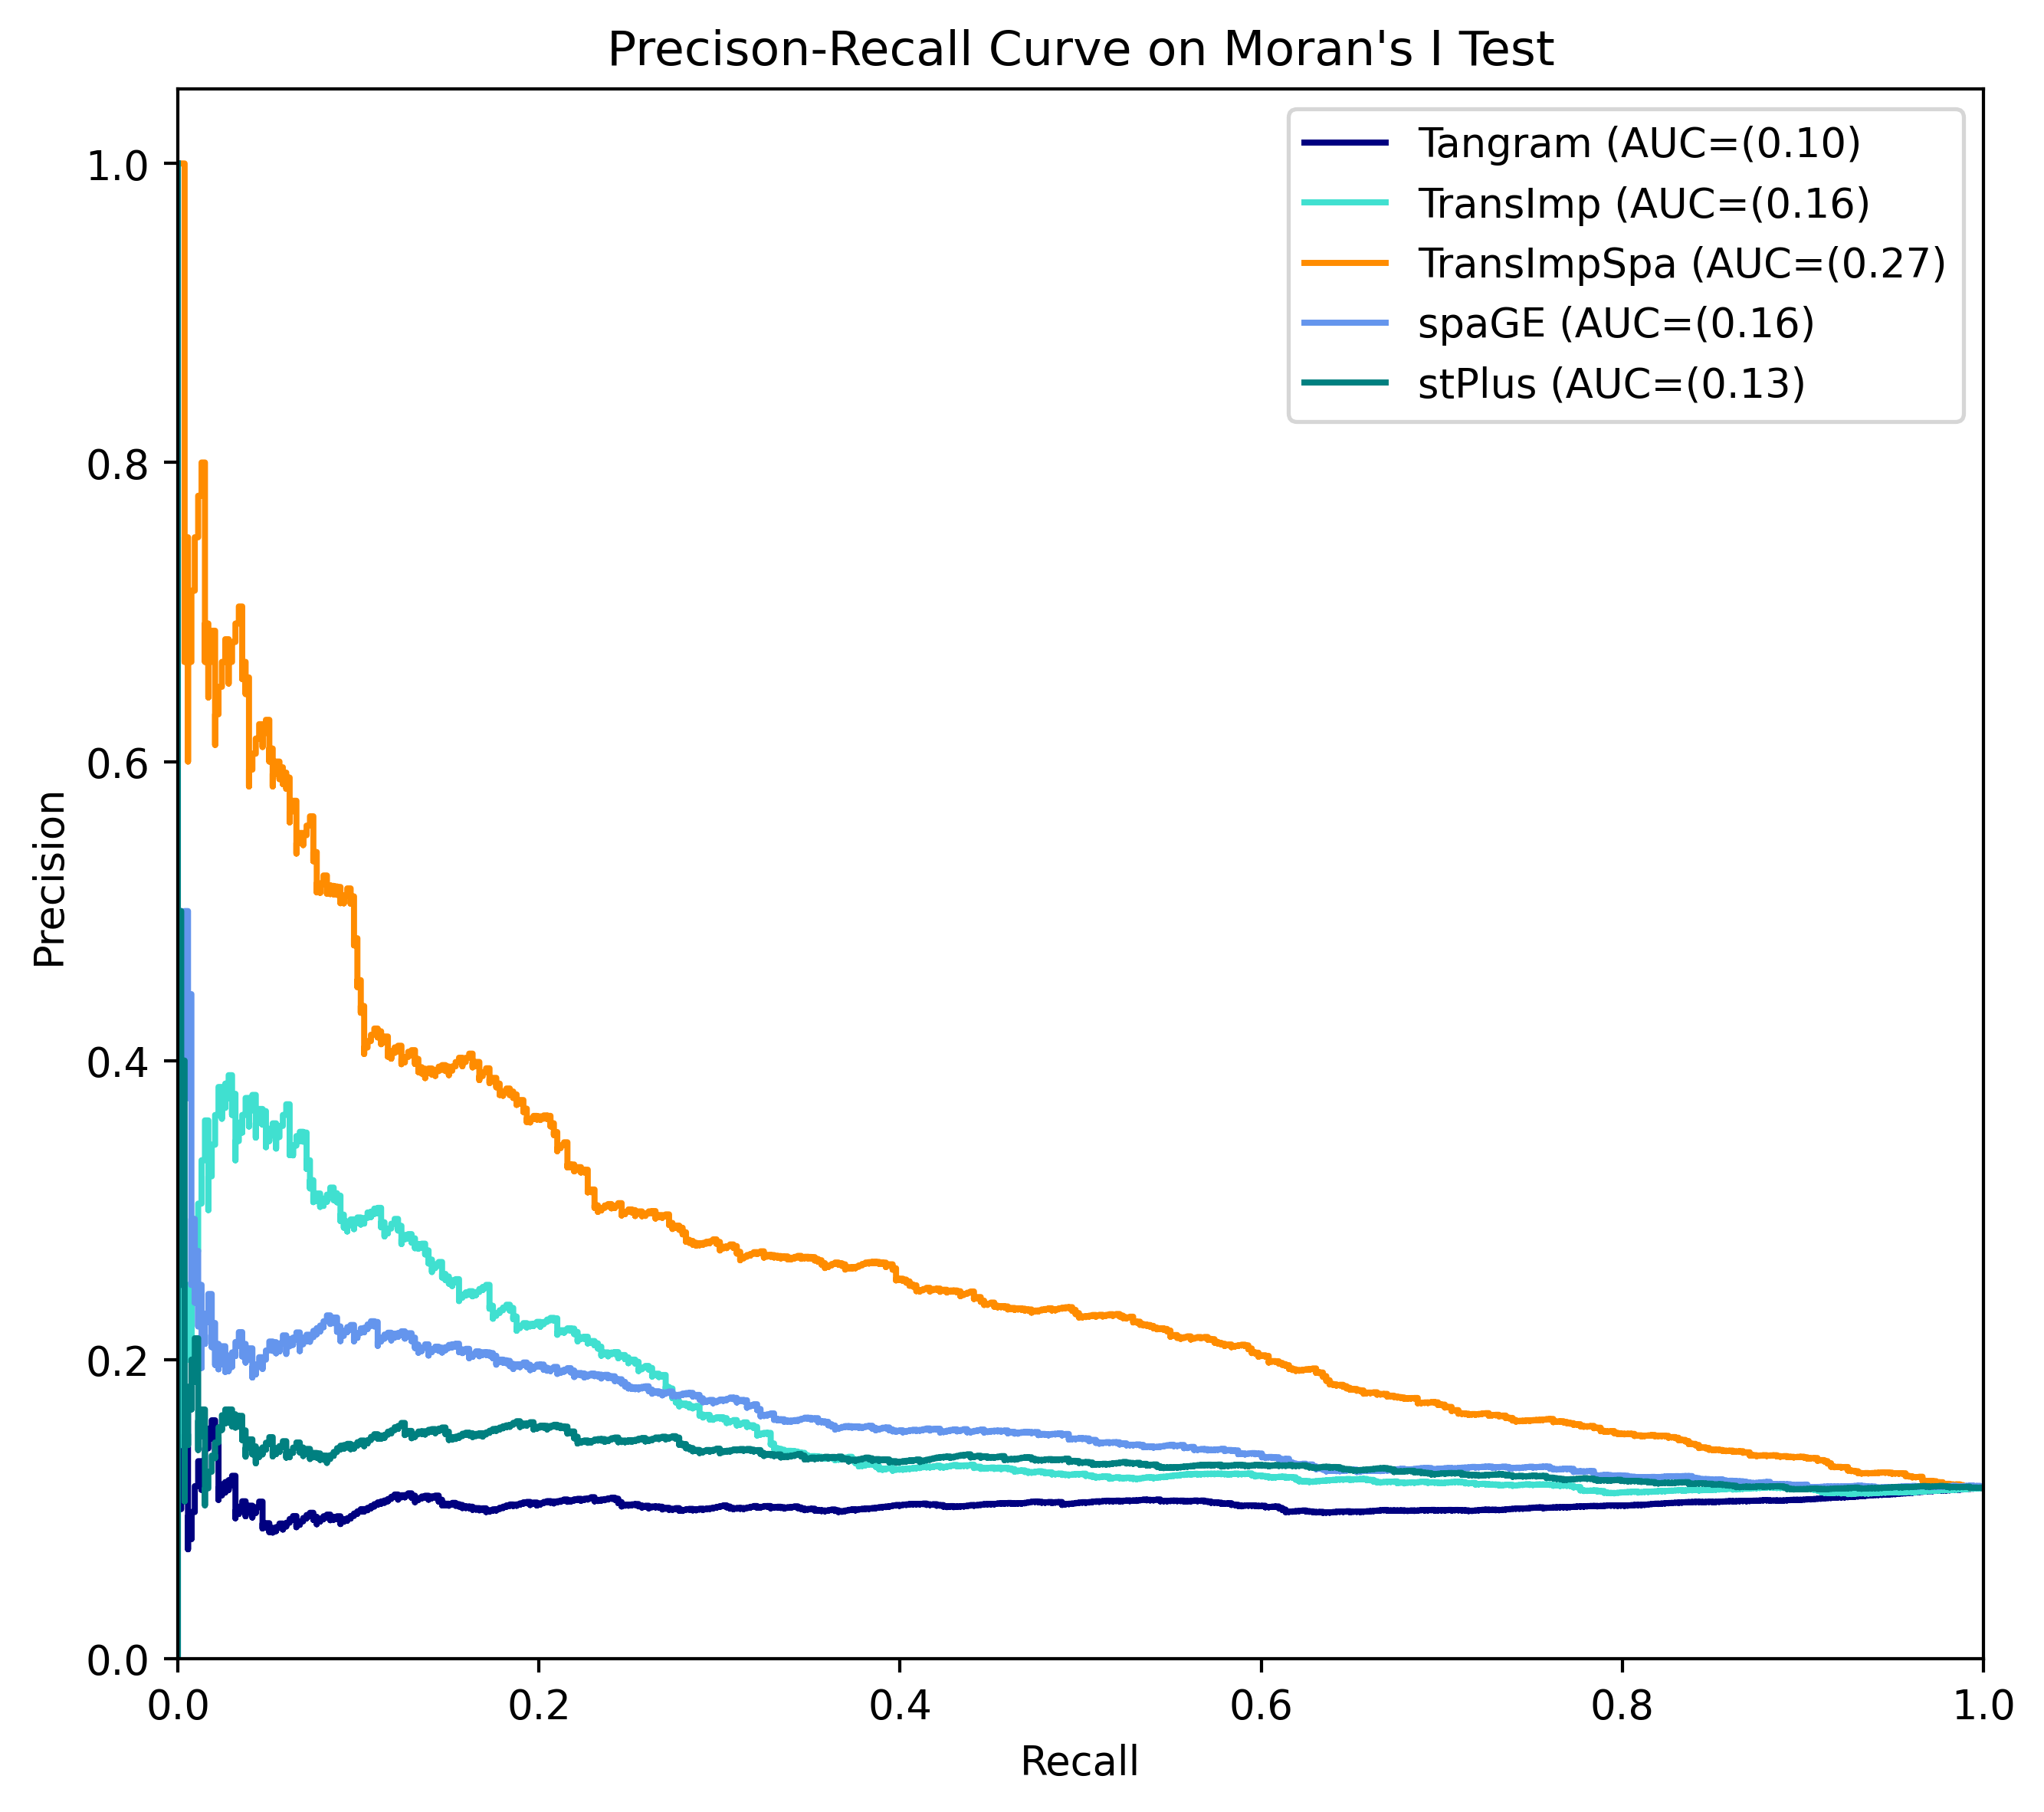

In [16]:
from sklearn import metrics
from matplotlib import pyplot as plt

idx = -1
color = ['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal', 'red', 'blue', 'grey']
plt.rcParams["figure.dpi"] = 380
_, ax = plt.subplots(figsize=(8, 7))
for method in df_corr.columns:
    # predict zero, 1-score
    if method in {'TransImpCls', 'TransImpClsSpa'}: continue
    sel = (~np.isnan(df_I['truth'].values) )& (~np.isnan(df_I[method].values))
    sel = sel & (df_I.truth.values > 0)
    print(f'({method}) Valid genes: {sel.sum()}/{sel.shape[0]}')
    y, score = df_issig.truth.values[sel], df_issig[method][sel]
    I = df_I[method][sel]
    
    print(method)
    preds = score < thred

    cm = metrics.confusion_matrix(y < thred, preds, labels=[0, 1])
    print(f"FPR: {cm[0][1]/(cm[0][1] + cm[0][0]):.6f}")
    if not method in {"transImpCls", "transImpute", "transImpClsSpa"}:
        idx += 1
    else:
        continue      

    
    prec, rec, thresholds  = metrics.precision_recall_curve(y < thred, I, pos_label=1)
    
    auc_score = metrics.auc(rec, prec)
    
    disp = metrics.PrecisionRecallDisplay(precision=prec, recall=rec)
    
    disp.plot(ax=ax, name = f"{method} (AUC=({auc_score:.2f})", color=color[idx])
    
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])

ax.set_title(f"Precison-Recall Curve on Moran's I Test")
ax.legend(loc="best")
plt.show()

(Tangram) Valid genes: 4670/7068
Tangram
FPR: 0.963500
(TransImp) Valid genes: 4670/7068
TransImp
FPR: 0.995407
(TransImpSpa) Valid genes: 4670/7068
TransImpSpa
FPR: 0.722746
(spaGE) Valid genes: 4670/7068
spaGE
FPR: 0.896785
(stPlus) Valid genes: 4670/7068
stPlus
FPR: 0.930868


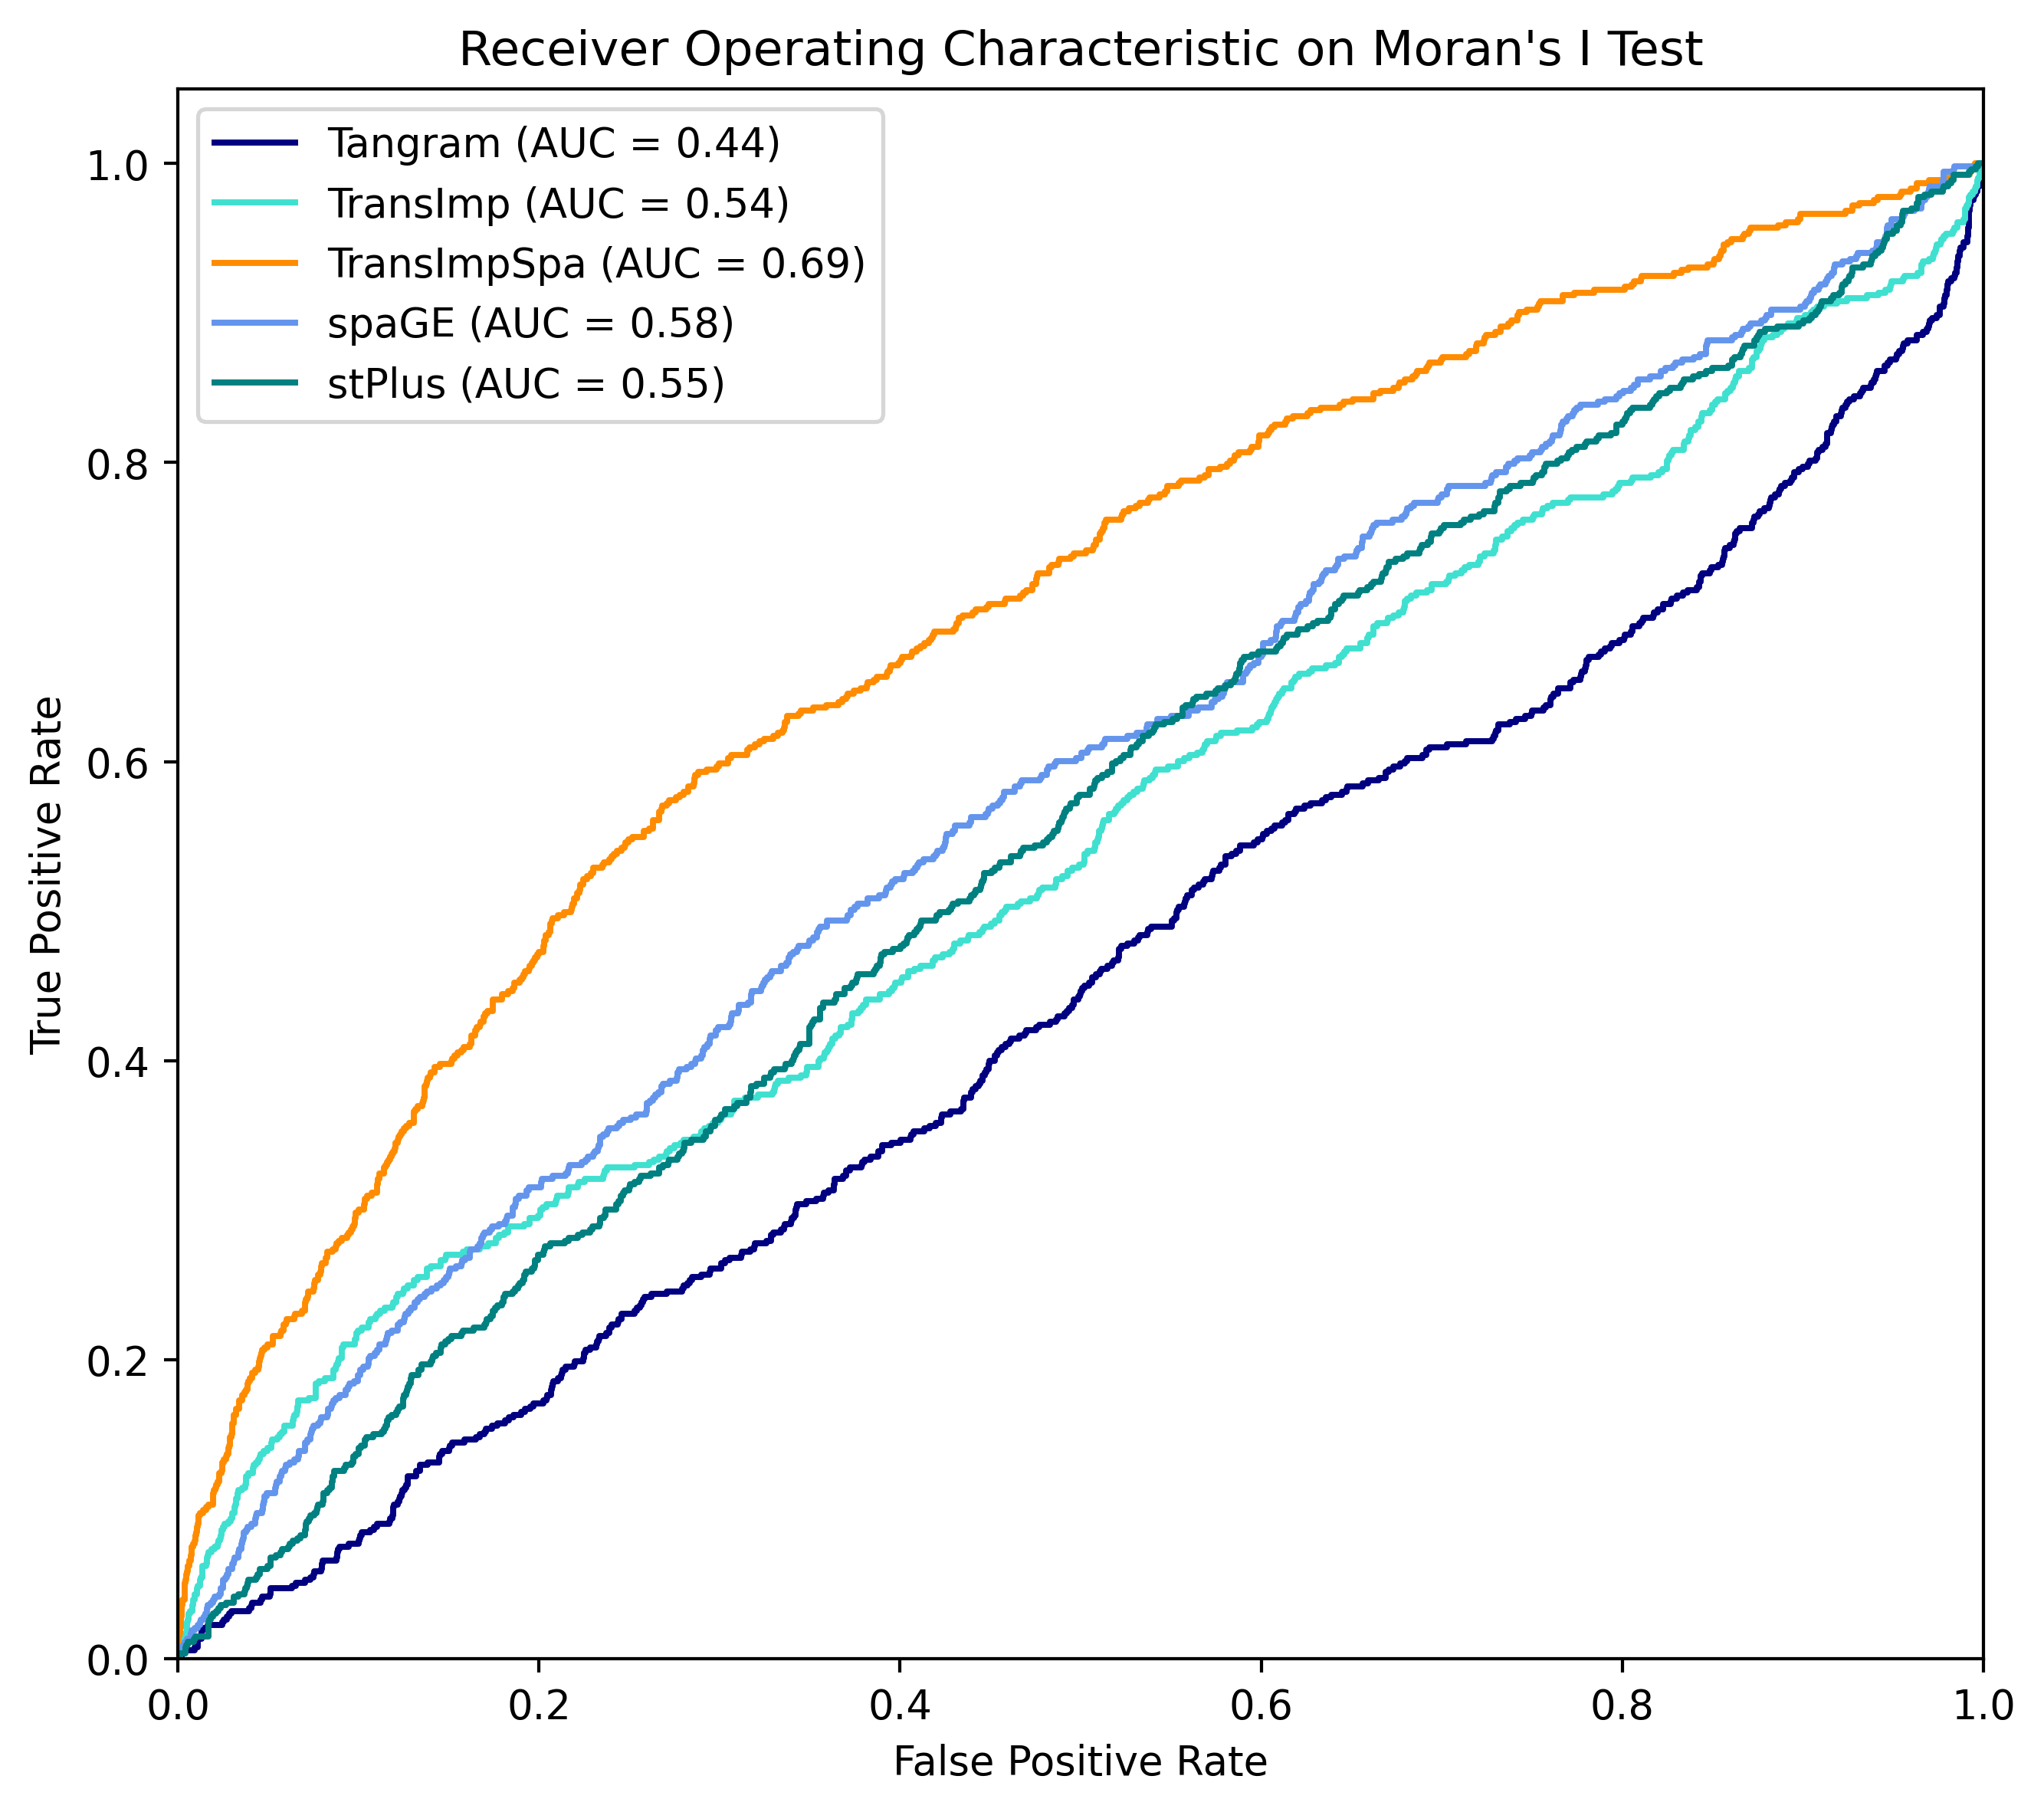

<Figure size 2432x1824 with 0 Axes>

<Figure size 2432x1824 with 0 Axes>

<Figure size 2432x1824 with 0 Axes>

<Figure size 2432x1824 with 0 Axes>

<Figure size 2432x1824 with 0 Axes>

In [17]:
from sklearn import metrics
from matplotlib import pyplot as plt
# tred = 1e-2
fprs = []
plt.rcParams["figure.dpi"] = 380
_, ax = plt.subplots(figsize=(8, 7))
idx = -1
for method in df_corr.columns:
    # predict zero, 1-score
    if method in {'TransImpCls', 'TransImpClsSpa'}: continue

    sel = (~np.isnan(df_I['truth'].values) )& (~np.isnan(df_I[method].values))
    sel = sel & (df_I.truth.values > 0) 
    
    print(f'({method}) Valid genes: {sel.sum()}/{sel.shape[0]}')
    y, score = df_issig.truth.values[sel], df_issig[method][sel]
    I = df_I[method][sel]
    
    print(method)
    preds = score < thred
    
    cm = metrics.confusion_matrix(y < thred, preds, labels=[0, 1])
    print(f"FPR: {cm[0][1]/(cm[0][1] + cm[0][0]):.6f}")
    if not method in {"transImpCls", "transImpute", "transImpClsSpa"}:
        fprs.append({"Method": method, 'False Positive Rate':cm[0][1]/(cm[0][1] + cm[0][0]), "Test": "Moran's I"})
        idx += 1
    else:
        continue
    fpr, tpr, thresholds  = metrics.roc_curve(y < thred, I, pos_label=1)
    
    auc_score = metrics.auc(fpr, tpr)
    plt.figure()
    lw = 2
    disp = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr)
    disp.plot(ax=ax, name=f"{method} (AUC = {auc_score:.2f})", color=color[idx])
    


ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])

ax.set_title(f"Receiver Operating Characteristic on Moran's I Test")
ax.legend(loc="best")
plt.show()


(Tangram) Valid genes: 4670/7068
Tangram
FPR: 0.963500
prec: 0.11657801418439716, recl: 0.9868667917448405,  F1: 0.2085232903865213
(TransImp) Valid genes: 4670/7068
TransImp
FPR: 0.995407
prec: 0.11440860215053764, recl: 0.99812382739212,  F1: 0.20528651360216088
(TransImpCls) Valid genes: 4670/7068
TransImpCls
FPR: 0.976795
prec: 0.11556139198949442, recl: 0.9906191369606003,  F1: 0.20697765582124655
(TransImpClsSpa) Valid genes: 4670/7068
TransImpClsSpa
FPR: 0.532753
prec: 0.11910471622701839, recl: 0.5590994371482176,  F1: 0.19637561779242177
(TransImpSpa) Valid genes: 4670/7068
TransImpSpa
FPR: 0.722746
prec: 0.12032950867902324, recl: 0.7673545966228893,  F1: 0.20803662258392674
(spaGE) Valid genes: 4670/7068
spaGE
FPR: 0.896785
prec: 0.11855547636018056, recl: 0.9362101313320825,  F1: 0.2104597216364403
(stPlus) Valid genes: 4670/7068
stPlus
FPR: 0.930868
prec: 0.11755270394133822, recl: 0.9624765478424016,  F1: 0.20951603022258525


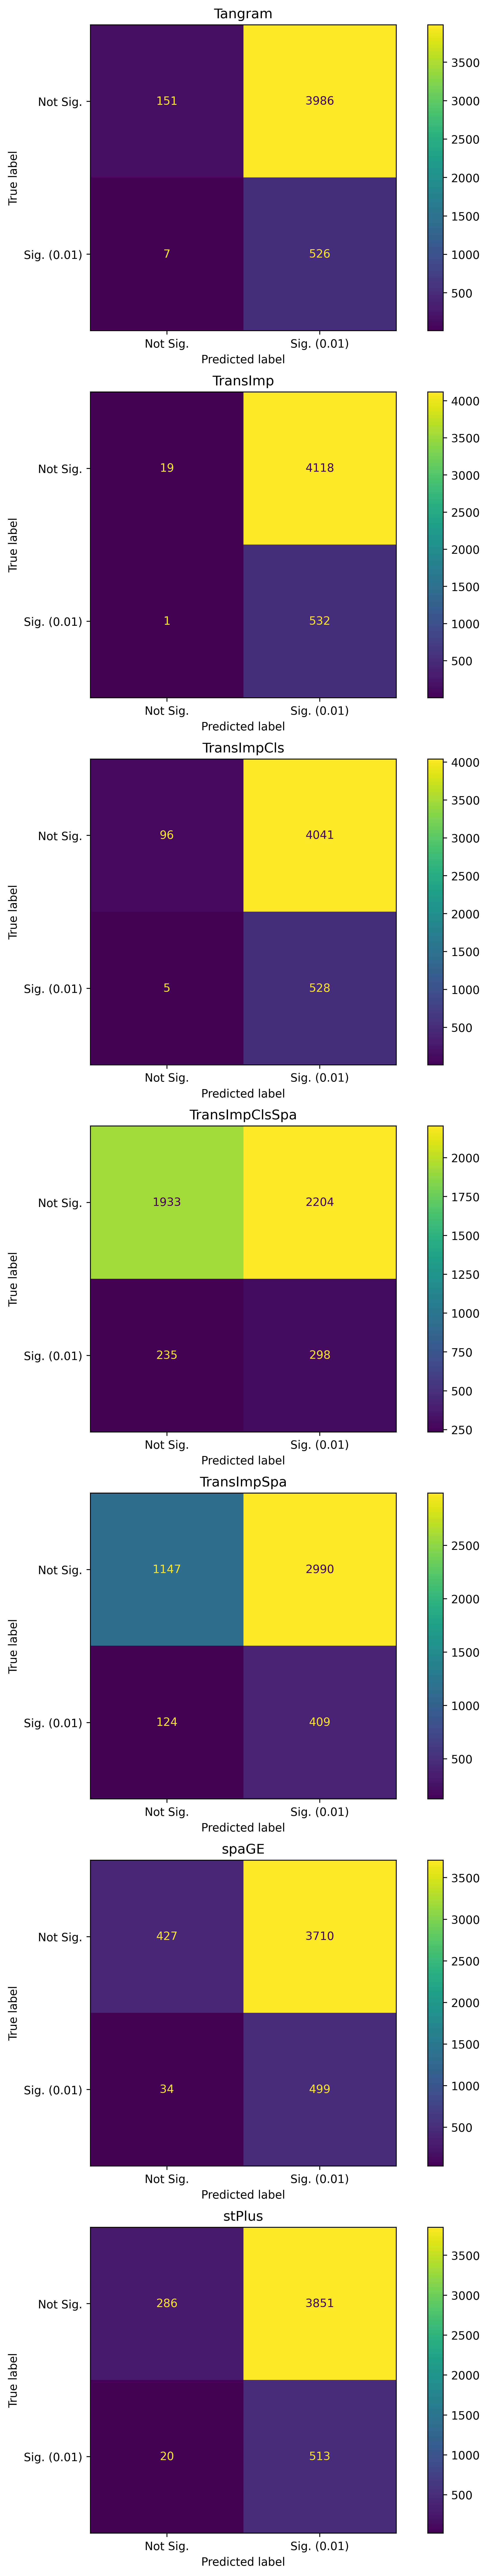

In [18]:
from sklearn import metrics
from matplotlib import pyplot as plt
# tred = 1e-2

_, axs = plt.subplots(7, figsize=(10, 40))
idx = -1
for method in df_corr.columns:
    # predict zero, 1-score
    # if method == "stPlus": continue
    # if not method in {"transImpCls", "transImpute", "transImpClsSpa"}:
    idx += 1
    # else:
        # continue
    sel = (~np.isnan(df_I['truth'].values) )& (~np.isnan(df_I[method].values))
    sel = sel & (df_I.truth.values > 0) # & (df_issig.truth.values == 0)
    # sel = sel & (spa_adata[:, df_I.index.values].uns['moranI'].pval_norm_fdr_bh.values < thred)
    print(f'({method}) Valid genes: {sel.sum()}/{sel.shape[0]}')
    y, score = df_issig.truth.values[sel], df_issig[method][sel]
    I = df_I[method][sel]
    
    print(method)
    preds = score < thred
    # print("precision ", metrics.precision_score(y < thred, preds))
    # print("recall", metrics.recall_score(y < thred , preds))
    cm = metrics.confusion_matrix(y < thred, preds, labels=[0, 1])
    print(f"FPR: {cm[0][1]/(cm[0][1] + cm[0][0]):.6f}")
    print(f"prec: {metrics.precision_score(y < thred, preds)}, recl: {metrics.recall_score(y < thred, preds)},  F1: {metrics.f1_score(y < thred, preds)}")
    disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=["Not Sig.", f"Sig. ({thred})"])
    disp.plot(ax=axs[idx])
    axs[idx].set_title(f"{method}")

plt.show()